回帰

150

clvなどの特徴量追加

## 必要なライブラリのimport

In [1]:
import warnings
import time
import pickle
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [2]:
# データの読み込み
path_train = '../../../../data/extornal/train_processed_clv.csv'
train = pd.read_csv(path_train)

# 目的変数と説明変数の作成
target = train['target']
del train['target']

In [3]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id']]
categorical_feats = ['feature_1','feature_2', 'feature_3',]
# 'hist_merchant_category_mode','hist_city_mode','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod',
# 'total_merchant_category_mode','total_city_mode','total_state_mode','total_category_1_mod','total_category_2_mod','total_category_3_mod',
# 'new_merchant_category_mode','new_city_mode','new_state_mode','new_category_1_mod','new_category_2_mod','new_category_3_mod']

In [4]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [5]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train))
predictions = np.zeros(len(target))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_50/', exist_ok=True)
    with open(f'../src/models/lgb_50/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.71029
[200]	valid_0's rmse: 3.66234
[300]	valid_0's rmse: 3.63906
[400]	valid_0's rmse: 3.62633
[500]	valid_0's rmse: 3.61923
[600]	valid_0's rmse: 3.61517
[700]	valid_0's rmse: 3.6123
[800]	valid_0's rmse: 3.61026
[900]	valid_0's rmse: 3.60856
[1000]	valid_0's rmse: 3.60777
[1100]	valid_0's rmse: 3.60715
[1200]	valid_0's rmse: 3.60661
[1300]	valid_0's rmse: 3.60595
[1400]	valid_0's rmse: 3.60558
[1500]	valid_0's rmse: 3.60536
[1600]	valid_0's rmse: 3.60552
[1700]	valid_0's rmse: 3.60539
Early stopping, best iteration is:
[1505]	valid_0's rmse: 3.60533
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.74281
[200]	valid_0's rmse: 3.69299
[300]	valid_0's rmse: 3.66882
[400]	valid_0's rmse: 3.65591
[500]	valid_0's rmse: 3.64895
[600]	valid_0's rmse: 3.6444
[700]	valid_0's rmse: 3.64161
[800]	valid_0's rmse: 3.63934
[900]	valid_0's rmse: 3.63773
[1000]

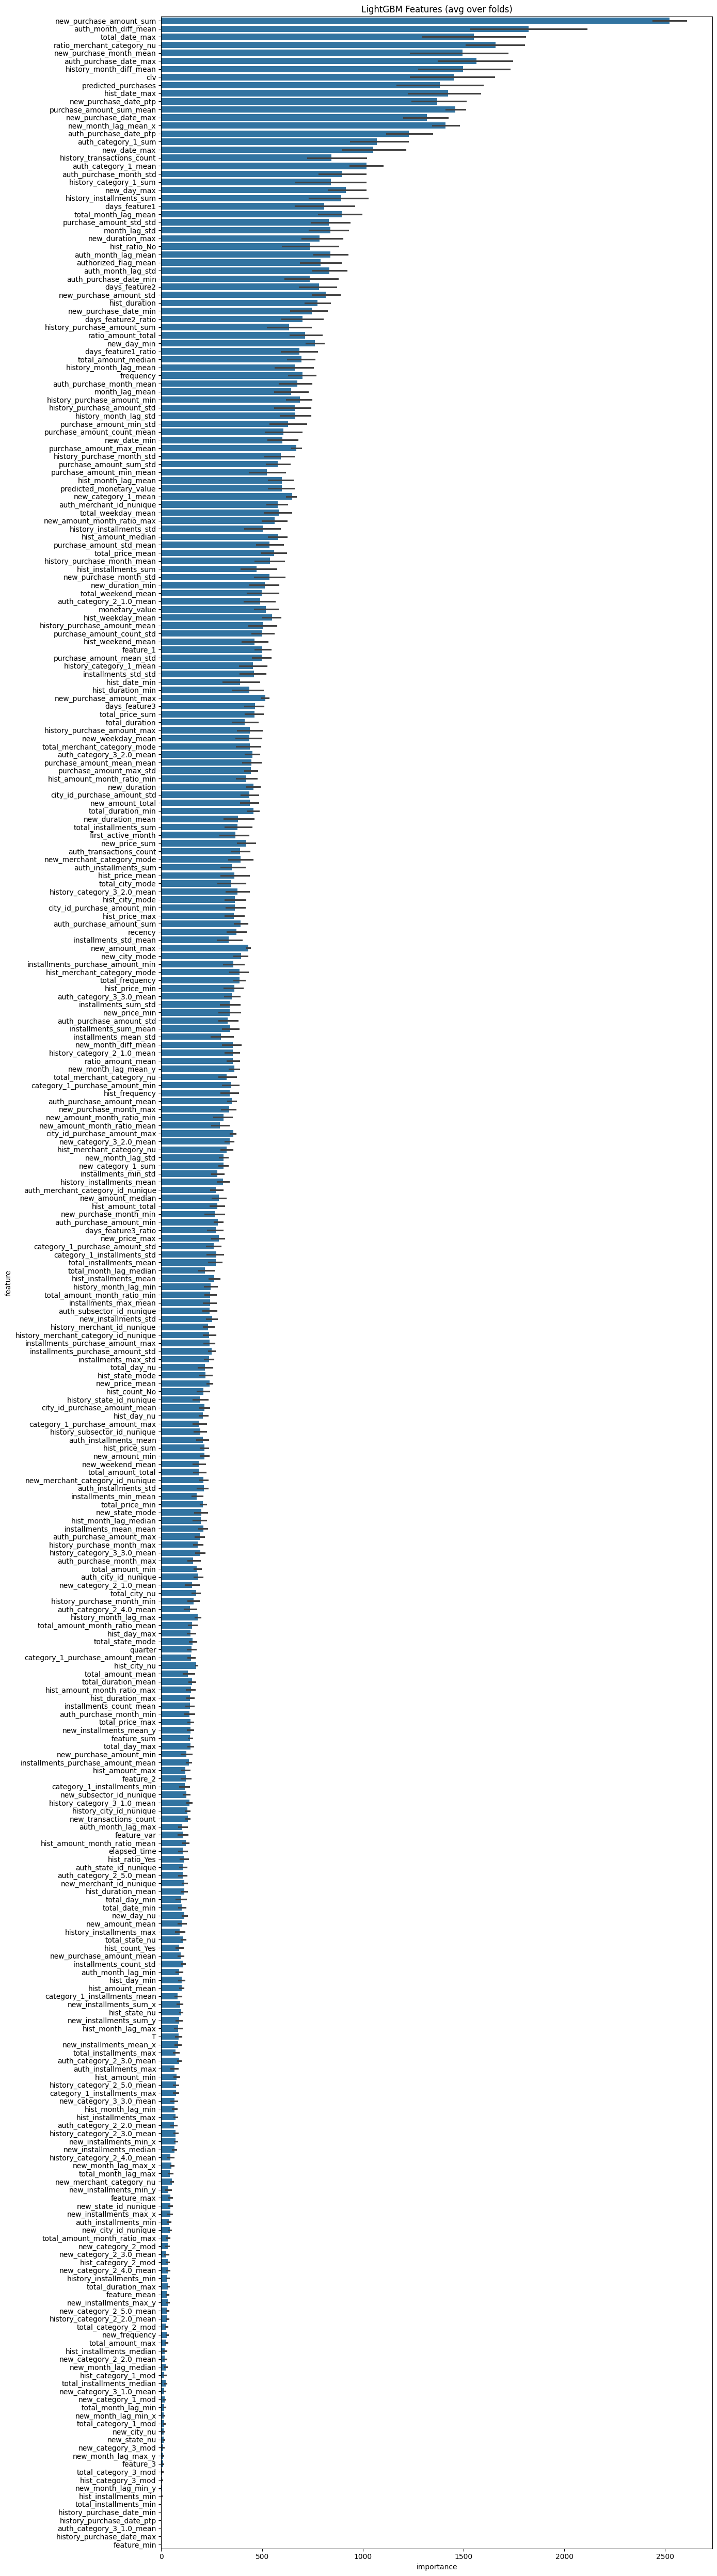

In [6]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

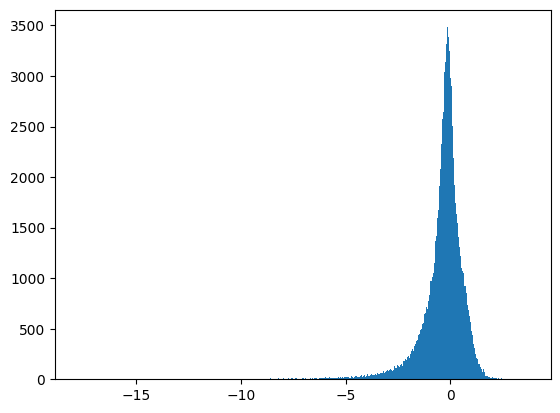

In [8]:
plt.hist(oof[oof<2**8],bins=1000)

In [11]:
feature = feature_importance_df.groupby('feature',as_index=False).importance.mean().sort_values('importance').reset_index(drop=True)
feature

,feature,importance
0,history_purchase_date_ptp,0.0
1,history_purchase_date_min,0.0
2,history_purchase_date_max,0.0
3,feature_min,0.0
4,auth_category_3_1.0_mean,0.0
...,...,...
309,total_date_max,1551.0
310,auth_purchase_date_max,1563.0
311,ratio_merchant_category_nu,1657.8
312,auth_month_diff_mean,1822.0


In [13]:
feature.describe()

,importance
count,314.000000
mean,357.229936
std,364.188049
min,0.000000
25%,104.950000
50%,251.400000
75%,486.150000
max,2521.800000


In [22]:
feature.query('importance>=105').head(20)

,feature,importance
79,elapsed_time,105.4
80,auth_state_id_nunique,106.2
81,auth_category_2_5.0_mean,106.4
82,feature_var,108.2
83,installments_count_std,109.4
84,total_state_nu,110.0
85,hist_ratio_Yes,111.8
86,new_day_nu,114.8
87,hist_duration_mean,115.2
88,new_merchant_id_nunique,115.4


In [19]:
feature.query('importance>=105').to_csv('../../../../data/processed/features_51.csv', index=False)
